In [1]:

#https://www.kaggle.com/datasets/samlearner/letterboxd-movie-ratings-data?select=ratings_export.csv
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import math
from scipy import stats
from scipy.linalg import lstsq

In [2]:
data2= pd.read_csv('/content/ratings4.csv')
data2.head()

,Date,Name,Year,Letterboxd URI,Rating
0,2022-09-02,La La Land,2016,https://boxd.it/a5fa,5.0
1,2022-09-02,Your Name.,2016,https://boxd.it/cUqs,5.0
2,2022-09-02,Kiki's Delivery Service,1989,https://boxd.it/1JAY,3.5
3,2022-09-02,My Neighbor Totoro,1988,https://boxd.it/20eA,3.5
4,2022-09-02,Ponyo,2008,https://boxd.it/1S0A,3.5


In [3]:
# Double the values in 'Rating' row
data2['Rating'] = data2['Rating'] * 2

# Replace the spaces in 'Name' row with '-'
data2['Name'] = data2['Name'].str.replace(' ', '-')

# Convert all values in 'Name' row to lowercase
data2['Name'] = data2['Name'].str.lower()

#rename columns
data2 = data2.rename(columns={'Rating': 'rating_val2', 'Name': 'movie_id'})


# Print the updated dataset
data2.head()


,Date,movie_id,Year,Letterboxd URI,rating_val2
0,2022-09-02,la-la-land,2016,https://boxd.it/a5fa,10.0
1,2022-09-02,your-name.,2016,https://boxd.it/cUqs,10.0
2,2022-09-02,kiki's-delivery-service,1989,https://boxd.it/1JAY,7.0
3,2022-09-02,my-neighbor-totoro,1988,https://boxd.it/20eA,7.0
4,2022-09-02,ponyo,2008,https://boxd.it/1S0A,7.0


In [4]:
data=pd.read_csv('/content/ratings_export.csv')
data.head()

,_id,movie_id,rating_val,user_id
0,5fc57c5d6758f6963451a07f,feast-2014,7,deathproof
1,5fc57c5d6758f6963451a063,loving-2016,7,deathproof
2,5fc57c5d6758f6963451a0ef,scripted-content,7,deathproof
3,5fc57c5d6758f6963451a060,the-future,4,deathproof
4,5fc57c5c6758f69634519398,mank,5,deathproof


In [5]:
# Create a set of unique movie IDs from 'data2'
valid_movie_ids = set(data2['movie_id'].unique())

# Filter 'data' to keep only rows with movie_ids present in 'valid_movie_ids'
filtered_data = data[data['movie_id'].isin(valid_movie_ids)]

# Print the updated dataset
filtered_data.head()

,_id,movie_id,rating_val,user_id
6,5fc57c5d6758f6963451a172,the-social-network,10,deathproof
74,5fc57c5e6758f6963451a744,good-burger,6,deathproof
205,5fc57c5e6758f6963451a69b,the-martian,8,deathproof
225,5fc57c5d6758f6963451a0b6,la-la-land,10,deathproof
261,5fc57c5d6758f6963451a1b0,train-to-busan,7,deathproof


In [6]:
# Count the number of common movies for each user in 'data' with 'data2'
common_movie_counts = filtered_data.groupby('user_id')['movie_id'].apply(lambda x: len(set(x) & set(data2['movie_id'])))

# Get the user IDs with at least 5 common movies
users_with_common_movies = common_movie_counts[common_movie_counts >= 5].index

# Filter 'data' to keep only the rows with users having at least 5 common movies
filtered_data = filtered_data[filtered_data['user_id'].isin(users_with_common_movies)]

filtered_data.head()

,_id,movie_id,rating_val,user_id
6,5fc57c5d6758f6963451a172,the-social-network,10,deathproof
74,5fc57c5e6758f6963451a744,good-burger,6,deathproof
205,5fc57c5e6758f6963451a69b,the-martian,8,deathproof
225,5fc57c5d6758f6963451a0b6,la-la-land,10,deathproof
261,5fc57c5d6758f6963451a1b0,train-to-busan,7,deathproof


In [7]:
# Merge 'data' and 'data2' based on 'movie_id'
merged_data = pd.merge(filtered_data, data2, on='movie_id')

# Get unique user IDs from 'data'
unique_user_ids = merged_data['user_id'].unique()

# Initialize a dictionary to store MSE values for each user
mse_values = {}

# Iterate over each unique user ID
for user_id in unique_user_ids:
    user_data = merged_data[merged_data['user_id'] == user_id]
    rating_data = user_data['rating_val']
    rating_data2 = user_data['rating_val2']

    # Perform least squares using scipy's lstsq function
    coefficients = lstsq(np.vstack((rating_data2, np.ones(len(rating_data2)))).T, rating_data)[0]

    # Calculate predicted ratings using the least squares solution
    predicted_ratings = coefficients[0] * rating_data2 + coefficients[1]

    # Calculate MSE between predicted and actual ratings
    mse = np.mean((rating_data - predicted_ratings) ** 2)

    # Store the MSE value for the user
    mse_values[user_id] = mse

# Sort the MSE values and get the top 10 most similar users
top_10_similar_users = sorted(mse_values, key=mse_values.get)[:10]

# Print the top 10 most similar users
for i, user_id in enumerate(top_10_similar_users, 1):
    print(f"User {user_id}: MSE = {mse_values[user_id]} (Rank {i})")


User localhero_: MSE = 0.0 (Rank 1)
User prestructural: MSE = 7.923826056907485e-32 (Rank 2)
User xescie: MSE = 2.253888300631462e-31 (Rank 3)
User dancruse: MSE = 4.507776601262924e-31 (Rank 4)
User joelca: MSE = 2.1036290805893647e-30 (Rank 5)
User neatwad: MSE = 2.208810534618833e-30 (Rank 6)
User doodlebunny64: MSE = 3.1554436208840472e-30 (Rank 7)
User eddysachdev: MSE = 3.1554436208840472e-30 (Rank 8)
User bdgrabinski: MSE = 5.784979971620753e-30 (Rank 9)
User iamjaywood: MSE = 8.835242138475332e-30 (Rank 10)


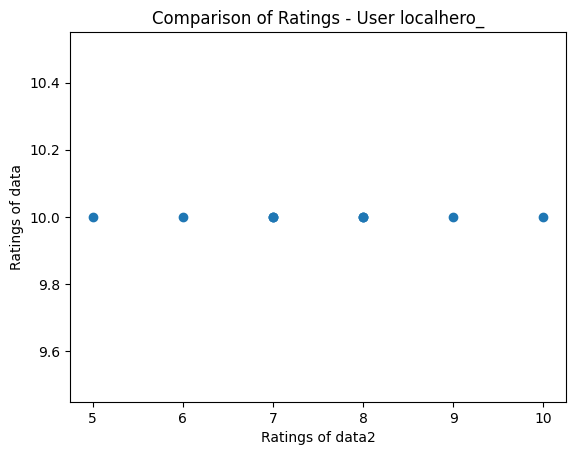

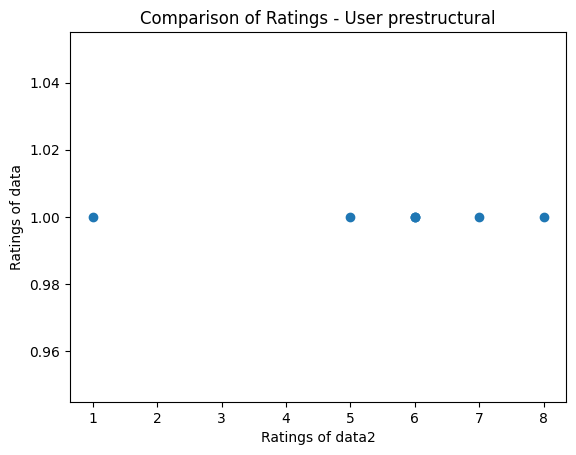

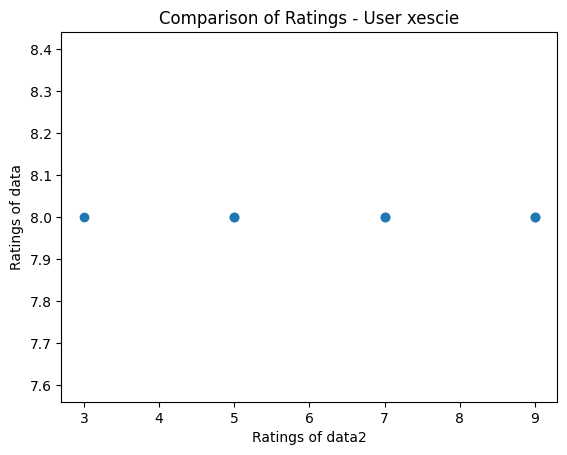

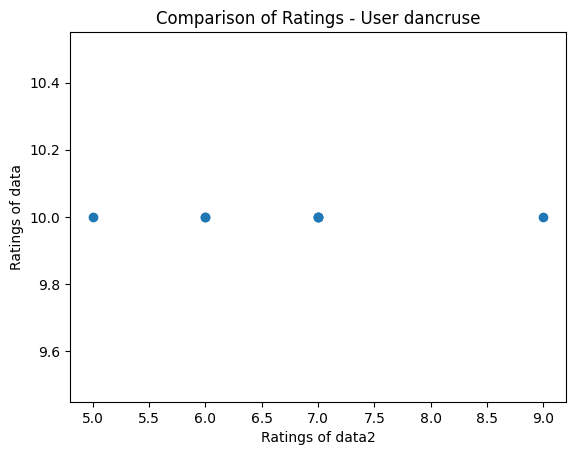

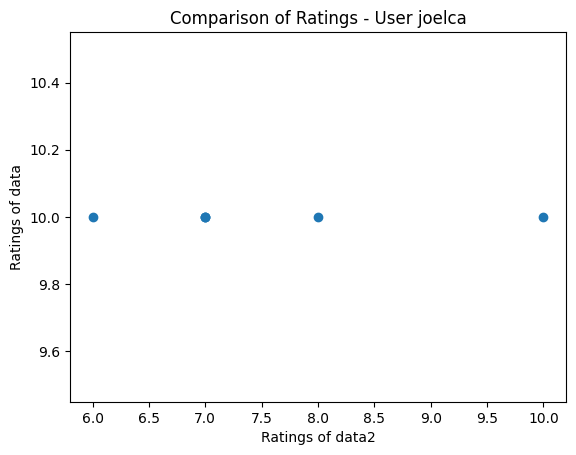

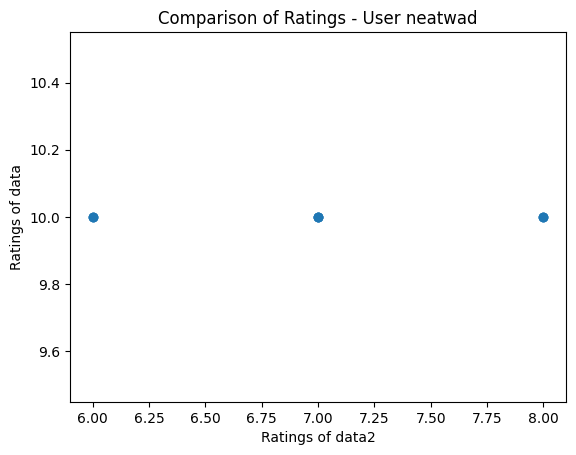

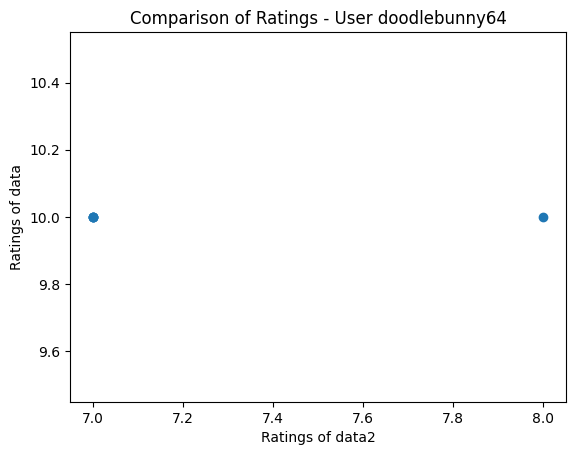

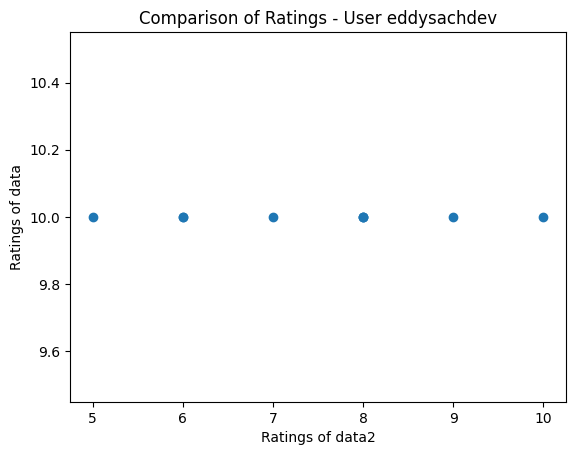

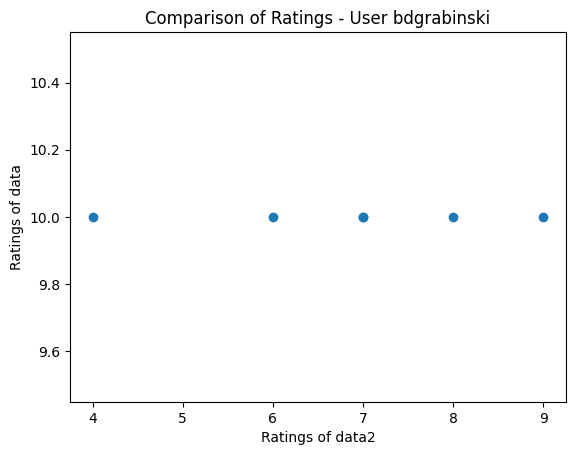

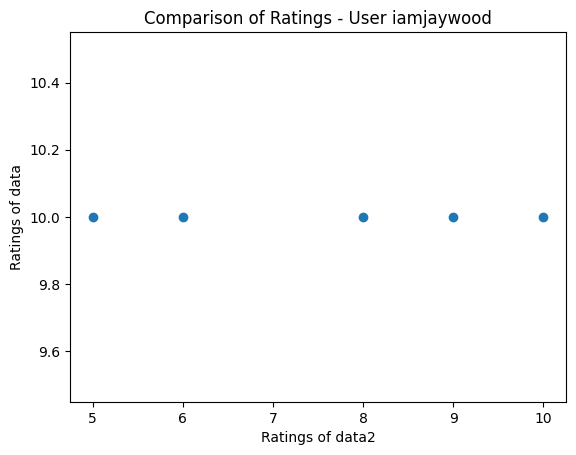

In [8]:
# Merge 'data' and 'data2' based on 'movie_id'
merged_data = pd.merge(filtered_data, data2, on='movie_id')

# Get unique user IDs from 'data'
unique_user_ids = merged_data['user_id'].unique()

# Initialize a dictionary to store MSE values for each user
mse_values = {}

# Iterate over each unique user ID
for user_id in unique_user_ids:
    user_data = merged_data[merged_data['user_id'] == user_id]
    rating_data = user_data['rating_val']
    rating_data2 = user_data['rating_val2']

    # Perform least squares using scipy's lstsq function
    coefficients = lstsq(np.vstack((rating_data2, np.ones(len(rating_data2)))).T, rating_data)[0]

    # Calculate predicted ratings using the least squares solution
    predicted_ratings = coefficients[0] * rating_data2 + coefficients[1]

    # Calculate MSE between predicted and actual ratings
    mse = np.mean((rating_data - predicted_ratings) ** 2)

    # Store the MSE value for the user
    mse_values[user_id] = mse

# Sort the MSE values and get the top 10 most similar users
top_10_similar_users = sorted(mse_values, key=mse_values.get)[:10]

# Plot the ratings for each user in separate plots
for i, user_id in enumerate(top_10_similar_users, 1):
    user_data = merged_data[merged_data['user_id'] == user_id]
    rating_data = user_data['rating_val']
    rating_data2 = user_data['rating_val2']

    # Create a new plot for each user
    plt.figure(i)

    # Plot ratings
    plt.scatter(rating_data2, rating_data)

    # Set plot labels and title
    plt.xlabel('Ratings of data2')
    plt.ylabel('Ratings of data')
    plt.title(f'Comparison of Ratings - User {user_id}')

# Show all the plots
plt.show()


In [9]:
# Calculate the count of each rating for each user
user_rating_counts = filtered_data.groupby(['user_id', 'rating_val']).size().reset_index(name='count')

# Calculate the total count of movies rated by each user
user_total_count = filtered_data.groupby('user_id').size().reset_index(name='total_count')

# Merge the rating counts and total counts dataframes
user_counts = pd.merge(user_rating_counts, user_total_count, on='user_id')

# Calculate the percentage of movies with the most frequent rating for each user
user_counts['percentage'] = user_counts['count'] / user_counts['total_count']

# Get the users who gave the same rating to almost all movies (e.g., 90% of movies)
users_to_delete = user_counts[user_counts['percentage'] >= 0.5].user_id

# Delete the rows from 'filtered_data' for the identified users
filtered_data = filtered_data[~filtered_data['user_id'].isin(users_to_delete)]

# Print the updated dataset
print(filtered_data)


                               _id             movie_id  rating_val  \
6         5fc57c5d6758f6963451a172   the-social-network          10   
74        5fc57c5e6758f6963451a744          good-burger           6   
205       5fc57c5e6758f6963451a69b          the-martian           8   
225       5fc57c5d6758f6963451a0b6           la-la-land          10   
261       5fc57c5d6758f6963451a1b0       train-to-busan           7   
...                            ...                  ...         ...   
11077894  6239f32ca936b95600b2f335   memories-of-murder           8   
11078037  6239f32ca936b95600b2f515  edward-scissorhands           7   
11078061  6239f32ca936b95600b2f55a          jojo-rabbit           7   
11078062  6239f32ca936b95600b2f55d  sorry-to-bother-you           8   
11078123  6239f32ca936b95600b2f61b                  saw           6   

             user_id  
6         deathproof  
74        deathproof  
205       deathproof  
225       deathproof  
261       deathproof  
...      

In [10]:
import pandas as pd
import numpy as np
from scipy.linalg import lstsq

# Assuming 'data' and 'data2' are DataFrames representing your datasets
# with column names as mentioned: 'rating_val', 'movie_id', 'user_id' in 'data'
# and 'rating_val2', 'movie_id' in 'data2'

# Merge 'data' and 'data2' based on 'movie_id'
merged_data = pd.merge(filtered_data, data2, on='movie_id')

# Get unique user IDs from 'data'
unique_user_ids = merged_data['user_id'].unique()

# Initialize a dictionary to store MSE values for each user
mse_values = {}

# Iterate over each unique user ID
for user_id in unique_user_ids:
    user_data = merged_data[merged_data['user_id'] == user_id]
    rating_data = user_data['rating_val']
    rating_data2 = user_data['rating_val2']

    # Perform least squares using scipy's lstsq function
    coefficients = lstsq(np.vstack((rating_data2, np.ones(len(rating_data2)))).T, rating_data)[0]

    # Calculate predicted ratings using the least squares solution
    predicted_ratings = coefficients[0] * rating_data2 + coefficients[1]

    # Calculate MSE between predicted and actual ratings
    mse = np.mean((rating_data - predicted_ratings) ** 2)

    # Store the MSE value for the user
    mse_values[user_id] = mse

# Sort the MSE values and get the top 10 most similar users
top_10_similar_users = sorted(mse_values, key=mse_values.get)[:10]

# Print the top 10 most similar users
for i, user_id in enumerate(top_10_similar_users, 1):
    print(f"User {user_id}: MSE = {mse_values[user_id]} (Rank {i})")


User colin_sharp: MSE = 0.09065934065934067 (Rank 1)
User sca__tterbrain: MSE = 0.1374999999999999 (Rank 2)
User welshvoxel: MSE = 0.14976958525345616 (Rank 3)
User honorszombie: MSE = 0.16666666666666652 (Rank 4)
User bickan: MSE = 0.2 (Rank 5)
User kidthe: MSE = 0.21052631578947353 (Rank 6)
User camillas: MSE = 0.23099415204678347 (Rank 7)
User ananasandre: MSE = 0.2333333333333333 (Rank 8)
User ahbr: MSE = 0.2638260432378079 (Rank 9)
User yakaminimanika: MSE = 0.2895833333333334 (Rank 10)


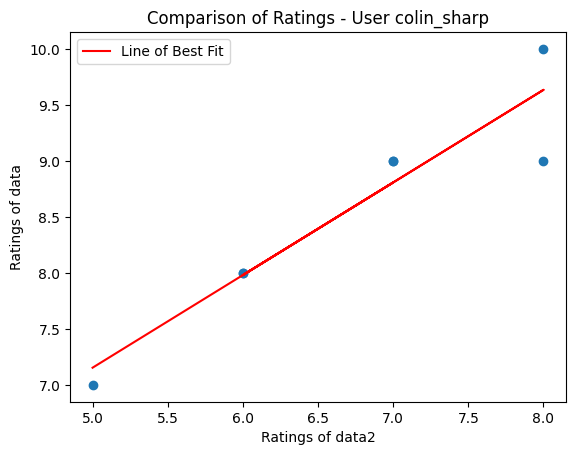

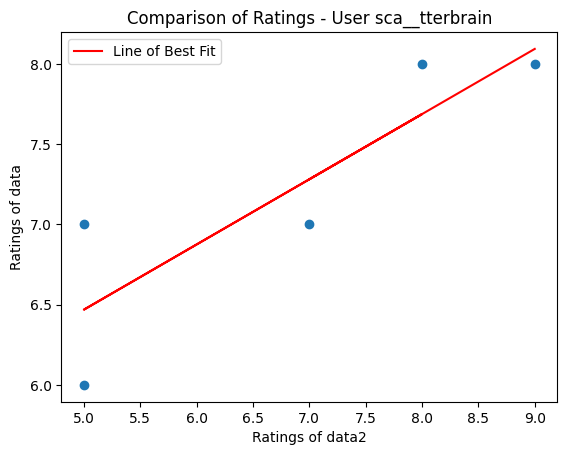

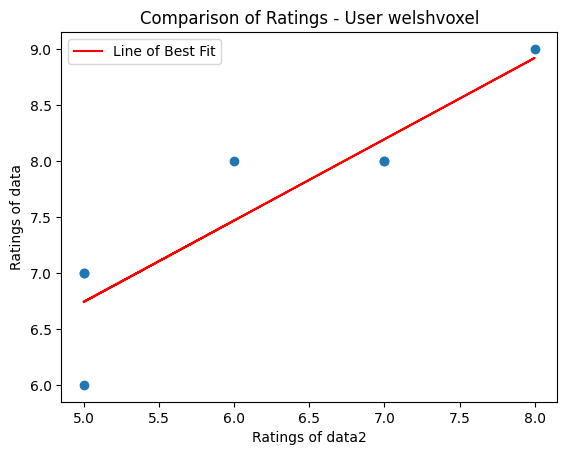

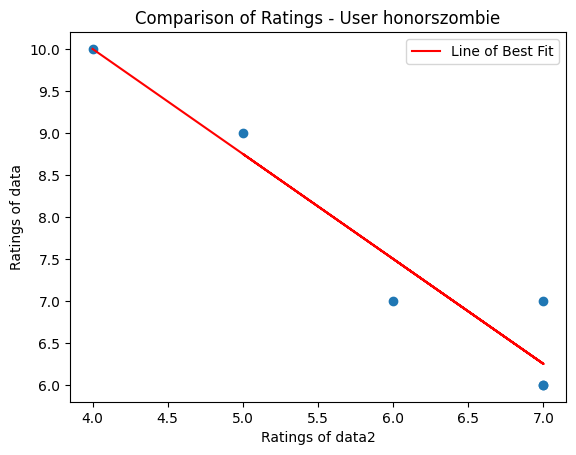

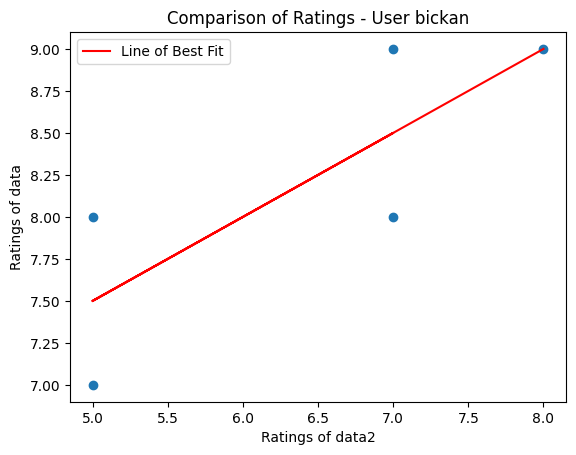

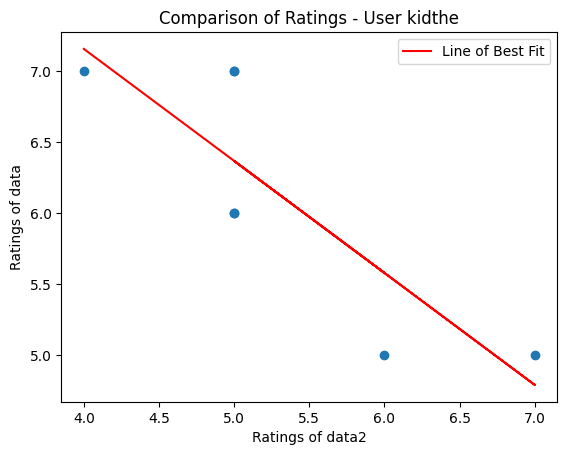

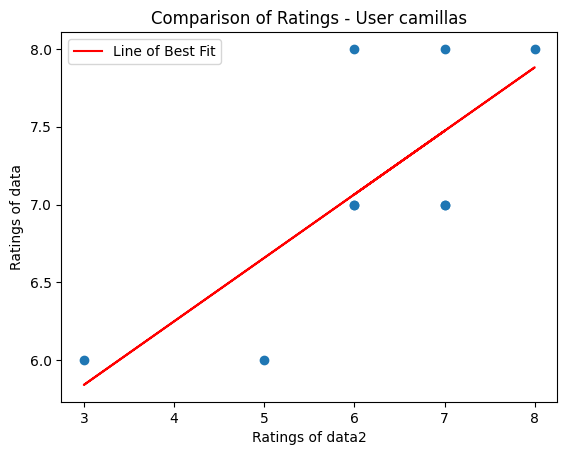

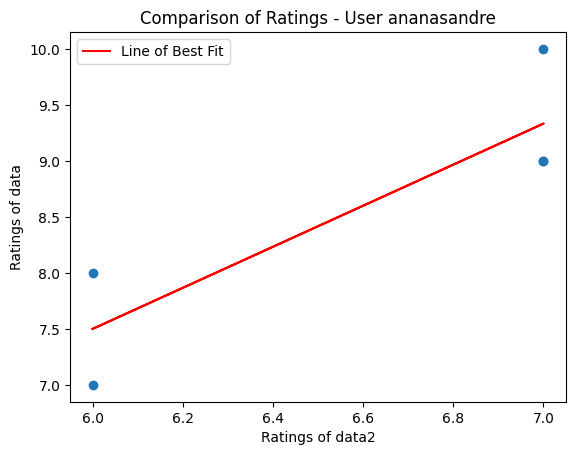

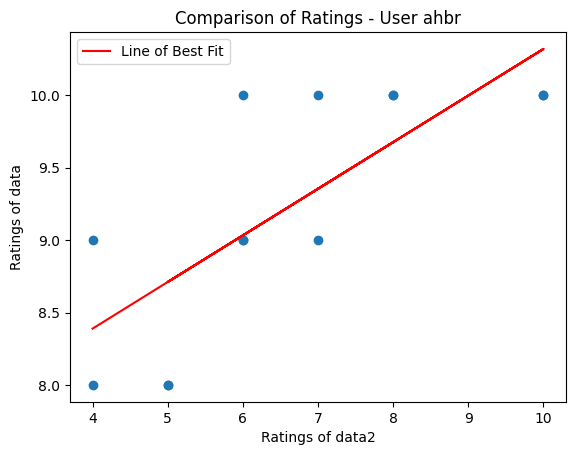

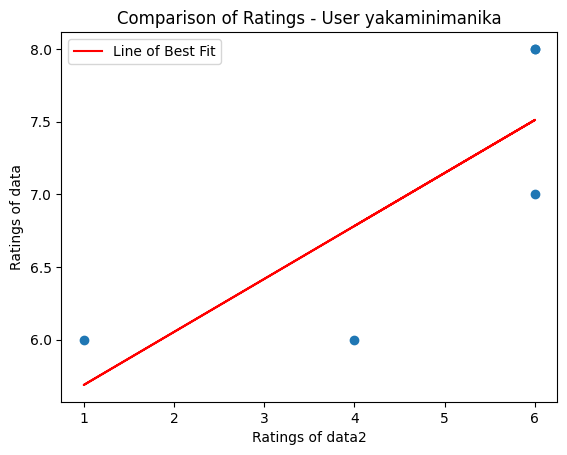

In [11]:
#remove 50% same users

# Merge 'data' and 'data2' based on 'movie_id'
merged_data = pd.merge(filtered_data, data2, on='movie_id')

# Get unique user IDs from 'data'
unique_user_ids = merged_data['user_id'].unique()

# Initialize a dictionary to store MSE values for each user
mse_values = {}

# Iterate over each unique user ID
for user_id in unique_user_ids:
    user_data = merged_data[merged_data['user_id'] == user_id]
    rating_data = user_data['rating_val']
    rating_data2 = user_data['rating_val2']

    # Perform least squares using scipy's lstsq function
    coefficients = lstsq(np.vstack((rating_data2, np.ones(len(rating_data2)))).T, rating_data)[0]

    # Calculate predicted ratings using the least squares solution
    predicted_ratings = coefficients[0] * rating_data2 + coefficients[1]

    # Calculate MSE between predicted and actual ratings
    mse = np.mean((rating_data - predicted_ratings) ** 2)

    # Store the MSE value for the user
    mse_values[user_id] = mse

# Sort the MSE values and get the top 10 most similar users
top_10_similar_users = sorted(mse_values, key=mse_values.get)[:10]

# Plot the ratings for each user in separate plots
for i, user_id in enumerate(top_10_similar_users, 1):
    user_data = merged_data[merged_data['user_id'] == user_id]
    rating_data = user_data['rating_val']
    rating_data2 = user_data['rating_val2']

    # Perform least squares using scipy's lstsq function
    coefficients = lstsq(np.vstack((rating_data2, np.ones(len(rating_data2)))).T, rating_data)[0]

    # Calculate predicted ratings using the least squares solution
    predicted_ratings = coefficients[0] * rating_data2 + coefficients[1]

    # Create a new plot for each user
    plt.figure(i)

    # Plot ratings
    plt.scatter(rating_data2, rating_data)

    # Plot the line of best fit in red
    plt.plot(rating_data2, predicted_ratings, color='red', label='Line of Best Fit')

    # Set plot labels and title
    plt.xlabel('Ratings of data2')
    plt.ylabel('Ratings of data')
    plt.title(f'Comparison of Ratings - User {user_id}')

    # Add legend
    plt.legend()

# Show all the plots
plt.show()


Rank: 1, User ID: colin_sharp, MSE: 0.09065934065934067
Rank: 2, User ID: sca__tterbrain, MSE: 0.1374999999999999
Rank: 3, User ID: welshvoxel, MSE: 0.14976958525345616
Rank: 4, User ID: bickan, MSE: 0.2
Rank: 5, User ID: camillas, MSE: 0.23099415204678347
Rank: 6, User ID: ananasandre, MSE: 0.2333333333333333
Rank: 7, User ID: ahbr, MSE: 0.2638260432378079
Rank: 8, User ID: yakaminimanika, MSE: 0.2895833333333334
Rank: 9, User ID: folklorish, MSE: 0.30377906976744196
Rank: 10, User ID: sunborne, MSE: 0.3086956521739132


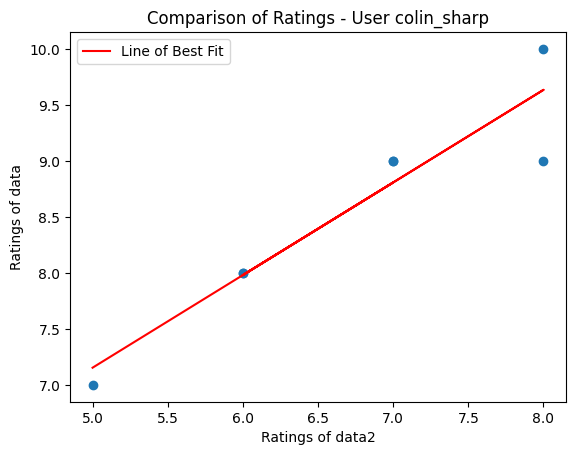

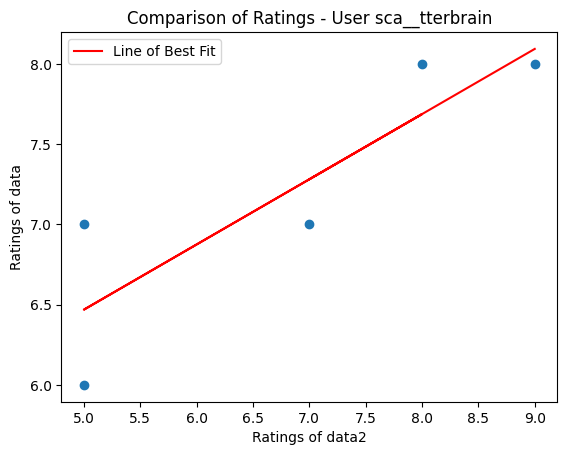

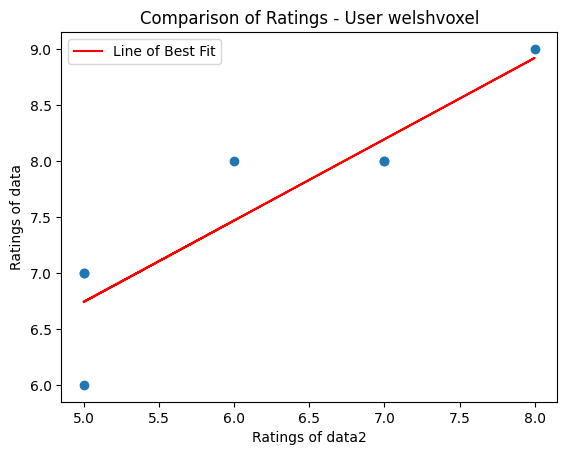

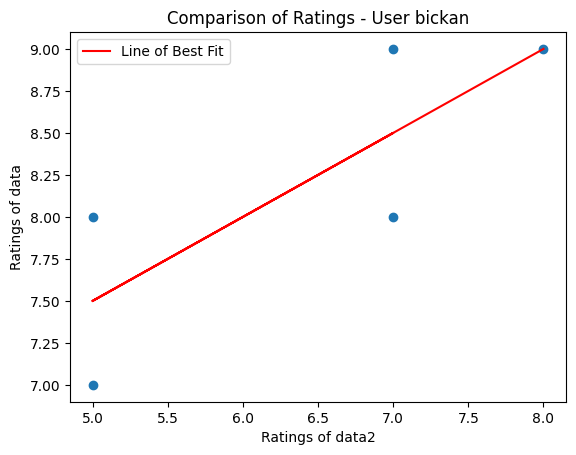

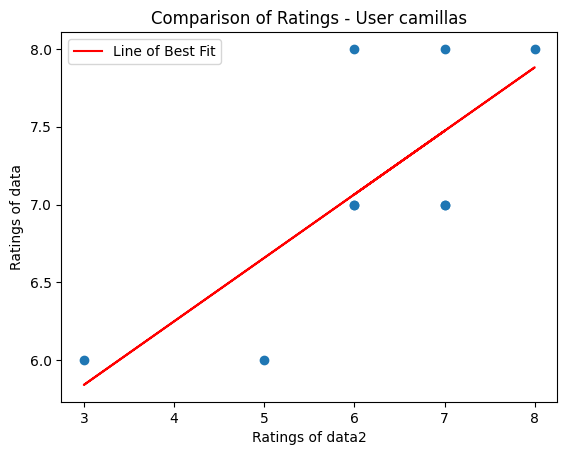

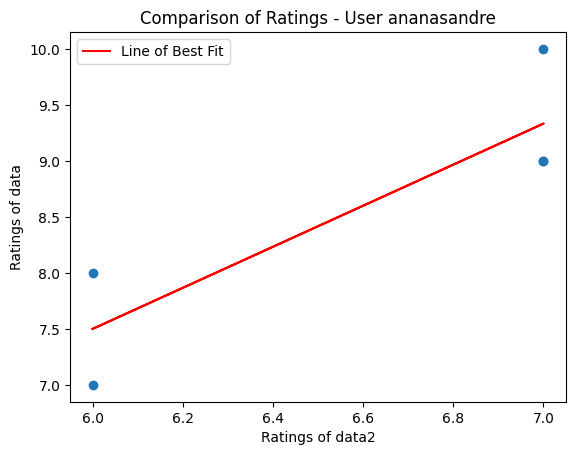

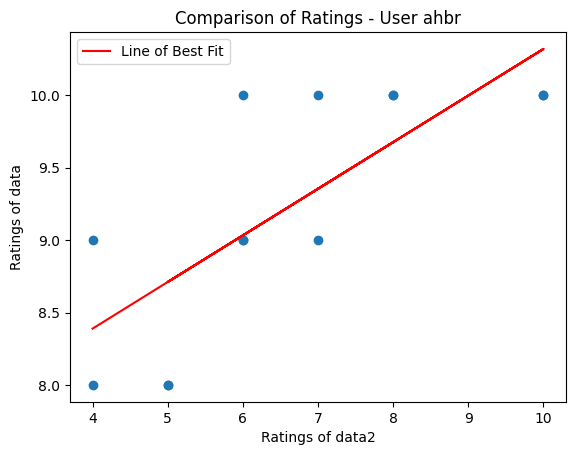

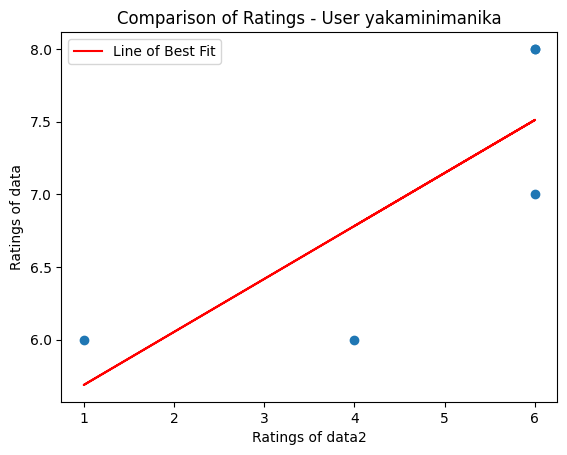

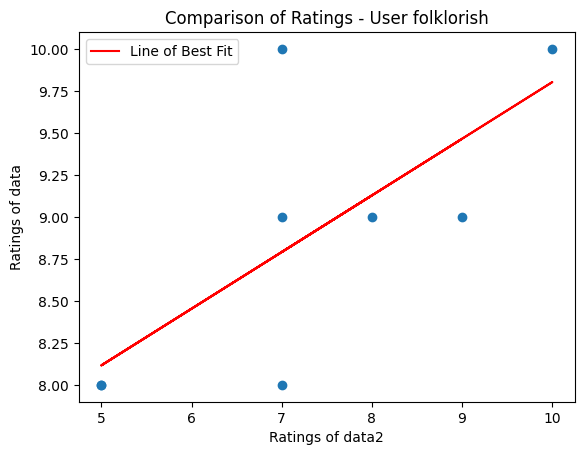

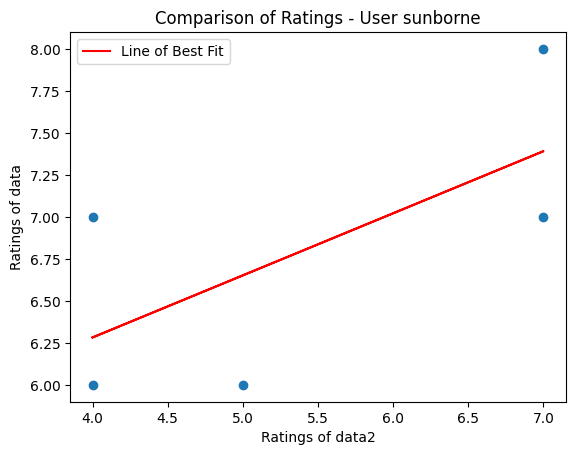

In [12]:
#remove 90% same users
#removes the negatives

# Merge 'data' and 'data2' based on 'movie_id'
merged_data = pd.merge(filtered_data, data2, on='movie_id')

# Get unique user IDs from 'data'
unique_user_ids = merged_data['user_id'].unique()

# Initialize a dictionary to store MSE values for each user
mse_values = {}

# Iterate over each unique user ID
for user_id in unique_user_ids:
    user_data = merged_data[merged_data['user_id'] == user_id]
    rating_data = user_data['rating_val']
    rating_data2 = user_data['rating_val2']

    # Perform least squares using scipy's lstsq function
    coefficients = lstsq(np.vstack((rating_data2, np.ones(len(rating_data2)))).T, rating_data)[0]

    # Calculate the slope of the least squares line
    slope = coefficients[0]

    # Check if the slope is greater than 0
    if slope > 0:
        # Calculate predicted ratings using the least squares solution
        predicted_ratings = coefficients[0] * rating_data2 + coefficients[1]

        # Calculate MSE between predicted and actual ratings
        mse = np.mean((rating_data - predicted_ratings) ** 2)

        # Store the MSE value for the user
        mse_values[user_id] = mse

# Sort the MSE values and get the top 10 most similar users
top_10_similar_users = sorted(mse_values, key=mse_values.get)[:10]

# Save the user_ids of the top 10 in an array
top_10_user_ids = top_10_similar_users.copy()

# Plot the ratings for each user in separate plots
for i, user_id in enumerate(top_10_similar_users, 1):
    user_data = merged_data[merged_data['user_id'] == user_id]
    rating_data = user_data['rating_val']
    rating_data2 = user_data['rating_val2']

    # Perform least squares using scipy's lstsq function
    coefficients = lstsq(np.vstack((rating_data2, np.ones(len(rating_data2)))).T, rating_data)[0]

    # Calculate the slope of the least squares line
    slope = coefficients[0]

    # Check if the slope is greater than 0
    if slope > 0:
        # Calculate predicted ratings using the least squares solution
        predicted_ratings = coefficients[0] * rating_data2 + coefficients[1]

        # Create a new plot for each user
        plt.figure(i)

        # Plot ratings
        plt.scatter(rating_data2, rating_data)

        # Plot the line of best fit in red
        plt.plot(rating_data2, predicted_ratings, color='red', label='Line of Best Fit')

        # Set plot labels and title
        plt.xlabel('Ratings of data2')
        plt.ylabel('Ratings of data')
        plt.title(f'Comparison of Ratings - User {user_id}')

        # Add legend
        plt.legend()

        # Print user's rank, user_id, and MSE
        rank = i
        mse = mse_values[user_id]
        print(f"Rank: {rank}, User ID: {user_id}, MSE: {mse}")

# Show all the plots
plt.show()


In [13]:
# Filter the DataFrame to keep only rows with user IDs in top_10_user_ids
filtered_data = data[data['user_id'].isin(top_10_user_ids)]

# Drop the 'user_id' column
filtered_data = filtered_data.drop('user_id', axis=1)

# Group the data by 'movie_id' and calculate the average rating and count of ratings
grouped_data = filtered_data.groupby('movie_id').agg({'rating_val': ['mean', 'count']})

# Flatten the column names
grouped_data.columns = ['average_rating', 'count']

# Sort the data by 'average_rating' and 'count' in descending order
recommendations = grouped_data.sort_values(by=['average_rating', 'count'], ascending=[False, False])

# Reset the index to have 'movie_id' as a regular column
recommendations = recommendations.reset_index()

# Calculate the ranking based on average rating and count
recommendations['ranking'] = recommendations.apply(lambda row: (row['average_rating'], row['count']), axis=1)
recommendations['ranking'] = recommendations['ranking'].rank(method='min', ascending=False)

# Save the sorted data to a new CSV file
recommendations.to_csv('recommendations.csv', index=False)

In [14]:
# Move the 'ranking' column from the end to the beginning
cols = recommendations.columns.tolist()
cols = ['ranking'] + cols[:-1]

# Reorder the columns in the DataFrame
recommendations = recommendations[cols]

# Save the updated DataFrame to a new CSV file
recommendations.to_csv('recommendations.csv', index=False)

In [15]:
# Load the recommendations.csv file
recommendations = pd.read_csv('recommendations.csv')

# Load the movie_data.csv file
movie_data = pd.read_csv('movie_data2_edit.csv')

# Merge the two dataframes based on the 'movie_id' column
merged_data = pd.merge(recommendations, movie_data, on='movie_id')

# Save the merged dataframe to a new CSV file
merged_data.to_csv('merged_recommendations.csv', index=False)
